In [1]:
!pip install adversarial-robustness-toolbox

     |████████████████████████████████| 1.1 MB 5.3 MB/s 
     |████████████████████████████████| 3.3 MB 31.1 MB/s 
     |████████████████████████████████| 26.3 MB 1.8 MB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2


In [2]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"


import random
import math
import sys
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.image as mpimg 

from tensorflow.keras.optimizers import Adam
import art
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import KerasClassifier

physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
from art.attacks.evasion import AutoProjectedGradientDescent
from art.attacks.evasion import Wasserstein
from art.attacks.evasion import DeepFool
from art.attacks.poisoning import PoisoningAttackAdversarialEmbedding

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

retval = os.getcwd()
print ("current Direction", retval)
os.chdir("/content/drive/My Drive/Cars/") 
retval = os.getcwd()
print ("current Direction", retval)
!rm -rf ipynb_checkpoints
!ls

current Direction /content
current Direction /content/drive/My Drive/Cars
alert.png  DamagedCars	UndamagedCars


In [5]:
"""
load model or use a random one
"""
# model = my_model()
# model.save('/content/drive/MyDrive/tmp/model')
model = tf.keras.models.load_model('/content/drive/MyDrive/tmp/model', compile=False)
# model.load_weights('/content/drive/MyDrive/tmp/model')
# x = tf.random.uniform((10, 3))
# model.evaluate(x_test,y_testdim1)

In [6]:
# L = 512
# H = 512
L = 224
H = 224
def change_to_right(wrong_labels):
    right_labels=[]
    for x in wrong_labels:
        for i in range(0,len(wrong_labels[0])):
            if x[i]==1:
                right_labels.append(i)
    return right_labels

def load_data():
  data_dir = "/content/drive/My Drive/Cars/"
  train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        validation_split = 0.3,
        horizontal_flip=True)
  train_generator = train_datagen.flow_from_directory(
        data_dir,

        target_size=(L, H),
        class_mode='categorical',
        subset='training')
  validation_generator = train_datagen.flow_from_directory(
    data_dir, # same directory as training data

    target_size=(L, H),
    class_mode='categorical',
    subset='validation') # set as validation data

  x_train = np.empty(shape=[0, L,H,3])
  y_train = []

  x_test = np.empty(shape=[0, L,H,3])
  y_test = []
  y_testdim1 = []
  train_num = 110#0
  test_num = 46#0
  for i in range(int(train_num/32)+1):
    x_train =  np.append(x_train, train_generator[i][0], axis = 0)
    y_train =np.append(y_train,train_generator[i][1])
  y_train = y_train.reshape(train_num,2)
  y_traindim1 =np.array(change_to_right(y_train))
  for i in range(int(test_num/32)+1):
    x_test = np.append(x_test, validation_generator[i][0], axis = 0)
    y_test =np.append(y_test,validation_generator[i][1])
  y_test = y_test.reshape(test_num,2)
  y_testdim1 =np.array(change_to_right(y_test))
  return x_train,y_train,x_test,y_test,y_traindim1,y_testdim1

In [7]:
x_train,y_train,x_test,y_test,y_traindim1,y_testdim1 = load_data()


Found 110 images belonging to 2 classes.
Found 46 images belonging to 2 classes.


In [8]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape,y_traindim1.shape,y_testdim1.shape

((110, 224, 224, 3), (46, 224, 224, 3), (110, 2), (46, 2), (110,), (46,))

In [9]:
def train_model(epoch,the_model):
  
  history = model.fit(train_generator,steps_per_epoch=100,epochs=epoch,verbose=1,validation_data=validation_generator,  
                      validation_steps=50)
  return history

In [10]:
def my_model():
    inputs = keras.Input(shape=(L, H, 3))
    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.02)(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Dropout(0.05)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
    outputs = layers.Dense(2 ,activation = 'softmax')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


model = my_model()

model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=3e-4),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 110, 110, 32)      0     

In [18]:
# FastGradientMethod
import tensorflow as tf

tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
import numpy as np

from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import KerasClassifier

model=my_model()
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=3e-4),loss='categorical_crossentropy',metrics=['accuracy'])
# Step 3: Create the ART classifier
min_pixel_value = 0
max_pixel_value = 1


classifier = KerasClassifier(model=model, clip_values=(min_pixel_value, max_pixel_value), use_logits=False)
# Step 4: Train the ART classifier
classifier.fit(x_train, y_train, batch_size=32, nb_epochs=6)


# Step 5: Evaluate the ART classifier on benign test examples

predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)

print("Accuracy on benign test examples: {}%".format(accuracy * 100))

# Step 6: Generate adversarial test examples
attack = FastGradientMethod(estimator=classifier, eps=0.2)
x_test_adv = attack.generate(x=x_test)

# Step 7: Evaluate the ART classifier on adversarial test examples

predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)

print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))

Train on 110 samples
Epoch 1/6
110/110 [==============================] - 1s 13ms/sample - loss: 2.9846 - accuracy: 0.5364
Epoch 2/6
110/110 [==============================] - 1s 10ms/sample - loss: 0.6974 - accuracy: 0.5545
Epoch 3/6
110/110 [==============================] - 1s 10ms/sample - loss: 0.6545 - accuracy: 0.5727
Epoch 4/6
110/110 [==============================] - 1s 10ms/sample - loss: 0.5567 - accuracy: 0.7273
Epoch 5/6
110/110 [==============================] - 1s 10ms/sample - loss: 0.7034 - accuracy: 0.7000
Epoch 6/6
110/110 [==============================] - 1s 10ms/sample - loss: 0.7390 - accuracy: 0.6909


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Accuracy on benign test examples: 60.86956521739131%
Accuracy on adversarial test examples: 36.95652173913043%


[[0.5034135  0.49658644]]
true_class: damagedcar
predicted_class: damagedcar


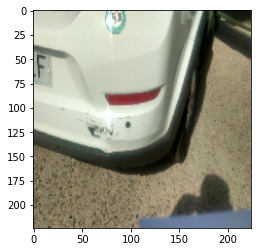

In [13]:
#Clean-Label Feature Collision Attacks on a Keras Classifier

class_descr = ['damagedcar','undamagedcar'] 
target_class = "damagedcar" # one of ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
target_label = np.zeros(len(class_descr))
target_label[class_descr.index(target_class)] = 1
target_instance = np.expand_dims(x_test[np.argmax(y_test, axis=1) == class_descr.index(target_class)][12], axis=0)

fig = plt.imshow(target_instance[0])
# print(np.argmax(classifier.predict(target_instance), axis=1)[0])
result = classifier.predict(target_instance)
print(result)
print('true_class: ' + target_class)
print('predicted_class: ' + class_descr[np.argmax(result, axis=1)[0]])

feature_layer = classifier.layer_names[-2]

[0. 1.]


array([[0.5034135 , 0.49658644]], dtype=float32)

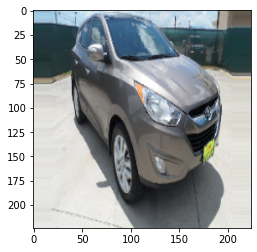

In [14]:
i = 35
fig = plt.imshow(x_test[i])
print(y_test[i])
result = classifier.predict(target_instance)
result

In [19]:
classifier.fit(x_train, y_train, batch_size=32, nb_epochs=5)

# Step 5: Evaluate the ART classifier on benign test examples
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

# Step 6: Generate adversarial test examples
attack = FastGradientMethod(estimator=classifier, eps=0.2)
x_test_adv = attack.generate(x=x_test)

# Step 7: Evaluate the ART classifier on adversarial test examples

predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on FastGradientMethod: {}%".format(accuracy * 100))

Train on 110 samples
Epoch 1/5
110/110 [==============================] - 1s 10ms/sample - loss: 0.5402 - accuracy: 0.6818
Epoch 2/5
110/110 [==============================] - 1s 10ms/sample - loss: 0.4018 - accuracy: 0.8727
Epoch 3/5
110/110 [==============================] - 1s 9ms/sample - loss: 0.3549 - accuracy: 0.8000
Epoch 4/5
110/110 [==============================] - 1s 10ms/sample - loss: 0.4846 - accuracy: 0.7727
Epoch 5/5
110/110 [==============================] - 1s 9ms/sample - loss: 0.2465 - accuracy: 0.9545
Accuracy on benign test examples: 63.04347826086957%
Accuracy on FastGradientMethod: 30.434782608695656%


In [30]:
#ProjectedGradientDescent
from art.data_generators import KerasDataGenerator
from art.defences.trainer import AdversarialTrainer
from art.attacks.evasion.projected_gradient_descent.projected_gradient_descent import ProjectedGradientDescent
datagen = ImageDataGenerator(
    horizontal_flip=True, width_shift_range=0.125, height_shift_range=0.125, fill_mode="constant", cval=0.0
)
datagen.fit(x_train)
batch_size = 55
art_datagen = KerasDataGenerator(
    datagen.flow(x=x_train, y=y_train, batch_size=batch_size, shuffle=True),
    size=x_train.shape[0],
    batch_size=batch_size,
)
# model = korobka
# classifier = KerasClassifier(model=model, clip_values=(min_pixel_value, max_pixel_value), use_logits=False)
# Create attack for adversarial trainer; here, we use 2 attacks, both crafting adv examples on the target model
pgd = ProjectedGradientDescent(classifier, eps=8 / 255, eps_step=2 / 255, max_iter=10, num_random_init=1)

# Create some adversarial samples for evaluation
x_test_pgd = pgd.generate(x_test)

# Create adversarial trainer and perform adversarial training
adv_trainer = AdversarialTrainer(classifier, attacks=pgd, ratio=1.0)
adv_trainer.fit_generator(art_datagen, nb_epochs=3)

# Evaluate the adversarially trained model on clean test set
labels_true = np.argmax(y_test, axis=1)
labels_test = np.argmax(classifier.predict(x_test), axis=1)
print("Accuracy test set: %.2f%%" % (np.sum(labels_test == labels_true) / x_test.shape[0] * 100))

# Evaluate the adversarially trained model on original adversarial samples
labels_pgd = np.argmax(classifier.predict(x_test_pgd), axis=1)
print(
    "Accuracy on original PGD adversarial samples: %.2f%%" % (np.sum(labels_pgd == labels_true) / x_test.shape[0] * 100)
)

# Evaluate the adversarially trained model on fresh adversarial samples produced on the adversarially trained model
x_test_pgd2 = pgd.generate(x_test)
labels_pgd = np.argmax(classifier.predict(x_test_pgd2), axis=1)
print("Accuracy on new PGD adversarial samples: %.2f%%" % (np.sum(labels_pgd == labels_true) / x_test.shape[0] * 100))

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

Precompute adversarial examples.:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/3 [00:00<?, ?it/s]

Accuracy test set: 78.26%
Accuracy on original PGD adversarial samples: 17.39%
Accuracy on new PGD adversarial samples: 21.74%


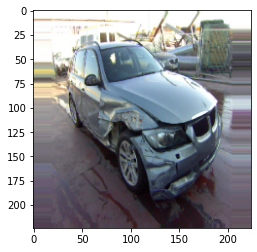

In [43]:
fig = plt.imshow(x_test_pgd[i])
fig2 = plt.imshow(x_test[15])

In [31]:
#DeepFool
# Create attack for adversarial trainer; here, we use 2 attacks, both crafting adv examples on the target model
depfl = DeepFool(classifier)

# Create some adversarial samples for evaluation
x_test_dpf = depfl.generate(x_test)

# Evaluate the adversarially trained model on clean test set
labels_true = np.argmax(y_test, axis=1)
labels_test = np.argmax(classifier.predict(x_test), axis=1)
print("Accuracy test set: %.2f%%" % (np.sum(labels_test == labels_true) / x_test.shape[0] * 100))

# Evaluate the adversarially trained model on original adversarial samples
labels_pgd = np.argmax(classifier.predict(x_test_dpf), axis=1)
print(
    "Accuracy on original DeepFool adversarial samples: %.2f%%" % (np.sum(labels_pgd == labels_true) / x_test.shape[0] * 100)
)

# Evaluate the adversarially trained model on fresh adversarial samples produced on the adversarially trained model
x_test_dpf2 = depfl.generate(x_test)
labels_pgd = np.argmax(classifier.predict(x_test_dpf2), axis=1)
print("Accuracy on new DeepFool samples: %.2f%%" % (np.sum(labels_pgd == labels_true) / x_test.shape[0] * 100))

DeepFool:   0%|          | 0/46 [00:00<?, ?it/s]

Accuracy test set: 78.26%
Accuracy on original DeepFool adversarial samples: 50.00%


DeepFool:   0%|          | 0/46 [00:00<?, ?it/s]

Accuracy on new DeepFool samples: 50.00%


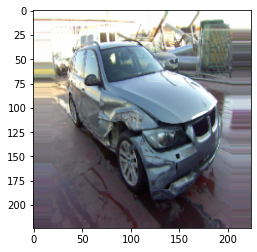

In [38]:
fig = plt.imshow(x_test_dpf[15])
# fig = plt.imshow(x_test_dpf2[i])

In [22]:
from art.attacks.poisoning.backdoor_attack import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd, add_single_bd, insert_image
from art.utils import to_categorical

from tests.utils import TestBase, master_seed, get_image_classifier_kr

def poison_func(x):
    return insert_image(x, backdoor_path='/content/drive/My Drive/Cars/alert.png',
                        size=(10,10), mode='RGB', blend=0.8, random=True)
backdoor_attack = PoisoningAttackBackdoor(poison_func)
poisoned_x, poisoned_y = backdoor_attack.poison(x_train[:110], y_train[:110])

labels_true = np.argmax(y_test, axis=1)
labels_test = np.argmax(classifier.predict(x_test), axis=1)
print("Accuracy test set: %.2f%%" % (np.sum(labels_test == labels_true) / x_test.shape[0] * 100))
# PoisoningAttack
model_pos=my_model()
model_pos.compile(optimizer=keras.optimizers.RMSprop(learning_rate=3e-5),loss='categorical_crossentropy',metrics=['accuracy'])

classifier_pos = KerasClassifier(model=model_pos, clip_values=(min_pixel_value, max_pixel_value), use_logits=False)
classifier_pos.fit(poisoned_x, poisoned_y, batch_size=10, nb_epochs=6)

# Evaluate the Poisoning trained model on original adversarial samples
labels_pgd = np.argmax(classifier_pos.predict(x_test), axis=1)
print(
    "Accuracy after Poisoned samples: %.2f%%" % (np.sum(labels_pgd == y_test) / poisoned_x.shape[0] * 100)
)


Accuracy test set: 82.61%
Train on 110 samples
Epoch 1/6
110/110 [==============================] - 3s 27ms/sample - loss: 0.8645 - accuracy: 0.5273
Epoch 2/6
110/110 [==============================] - 1s 12ms/sample - loss: 0.6436 - accuracy: 0.5818
Epoch 3/6
110/110 [==============================] - 1s 12ms/sample - loss: 0.5783 - accuracy: 0.7091
Epoch 4/6
110/110 [==============================] - 1s 12ms/sample - loss: 0.5497 - accuracy: 0.7182
Epoch 5/6
110/110 [==============================] - 1s 12ms/sample - loss: 0.4314 - accuracy: 0.8727
Epoch 6/6
110/110 [==============================] - 1s 12ms/sample - loss: 0.4150 - accuracy: 0.8273


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Accuracy after Poisoned samples: 0.00%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


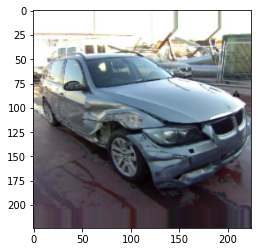

In [42]:
fig = plt.imshow(poisoned_x[i])

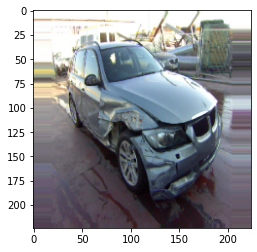

In [46]:
fig = plt.imshow(x_test[15])